# Introduction


This code presents a training of the pre-trained Faster R-CNN-ResNet-FPN model using torchvision to work with computer vision in the pytorch framework for single-class object detection (in the case of the pen detection dataset used). The dataset was taken from the [roboflow](https://universe.roboflow.com/zainab-aldhanhani/pen-nsayu/dataset/1) resource. The dataset is a csv file with data such as training image locations, image dimensions (width, height), class markup (class name), and bounding box coordinates.

In [50]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Data Preprocessing Pipeline

Creating a class for converting raw images to tensors, also for other image transformations

Due to the peculiarities of the training dataset, in order to avoid errors in the process of model training, it is necessary to execute code from the directory ../train/

In [52]:
%cd '.../pendataset/train'

/kaggle/input/pendataset/train


A class for converting a raw dataset into a tensors for model training with some input image transformations 

In [53]:
class CustomDataset(Dataset):
  def __init__(self, csv_file, transform=None):
    self.data = pd.read_csv(csv_file)
    self.transform = transform

  def __len__(self):
    return len(self.data)

# The second index indicates the number of the dataset column (starting from zero), 
# where the corresponding information is located 
  def __getitem__(self, idx):
    image_path = self.data.iloc[idx, 0]
    class_name = self.data.iloc[idx, 3]
    class_idx = class_name2idx_dict[class_name]
    xmin = self.data.iloc[idx, 4]
    ymin = self.data.iloc[idx, 5]
    xmax = self.data.iloc[idx, 6]
    ymax = self.data.iloc[idx, 7]

    image = Image.open(image_path).convert("RGB")
    target = {"boxes": torch.tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32),
                  "labels": torch.tensor([class_idx], dtype=torch.int64)}  # Assuming only one class (num_classes=1)
    
    if self.transform:
      image = self.transform(image)

    return image, target

In [54]:
import torchvision.transforms as T

# a function for image transformations
def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [55]:
# Training dataset path
TRAIN_DATASET_PATH = '_annotations.csv'

In [56]:
# Creating a dictionary of class name and index correspondence
class_names = pd.read_csv(TRAIN_DATASET_PATH).iloc[:, 3]

class_names = set(class_names)
idx2class_name_dict = {i+1 : name for i, name in enumerate(class_names)} # by the zero index the model denotes the background
class_name2idx_dict = {v : k for k, v in idx2class_name_dict.items()}

In [58]:
# Loading and preprocessing a training dataset
dataset = CustomDataset(TRAIN_DATASET_PATH, transform=get_transform(train=True))
print(f"Length of the Dataset: {len(dataset)}")
# Creating a data loader for a model
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

Length of the Dataset: 49


# Visualization of a sample training sample

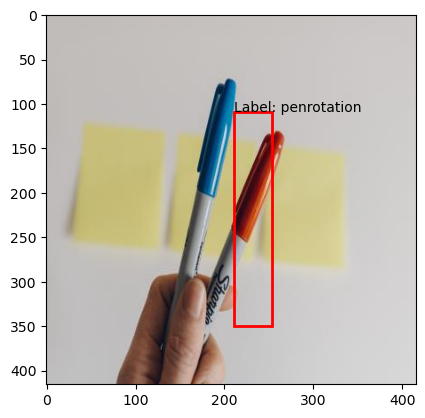

In [59]:
from random import randint

ds = pd.read_csv(TRAIN_DATASET_PATH)
rand_ds_el = randint(0, len(ds)-1)

xmin, ymin, xmax, ymax = ds.iloc[rand_ds_el, [4, 5, 6, 7]]
image_path = ds.iloc[rand_ds_el, 0]
label = ds.iloc[rand_ds_el, 3]

image = Image.open(image_path).convert("RGB")

plt.imshow(image)
ax = plt.gca()

rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor="r", facecolor="none")
ax.add_patch(rect)
ax.text(xmin, ymin, f"Label: {label}")

plt.show()

# Model Selection Pipeline

In [60]:
# Loading a pre-trained model Faster R-CNN-ResNet50-FPN
model = fasterrcnn_resnet50_fpn(pretrained=True, weights="DEFAULT", box_detections_per_img=10, box_nms_thresh=0.5, box_score_thresh=0.5)

In [61]:
# Freeze a certain number of model layers equal to the value of the num_layers_to_freeze variable. 
# The rest are used for fine-tining

NUM_LAYERS_TO_FREEZE = 80
f_l = 0
nml = 0
for param in model.parameters():
    if f_l < NUM_LAYERS_TO_FREEZE:
        param.requires_grad = False
        f_l += 1
        nml += 1
    else:
        param.requires_grad = True
        nml += 1
print(f"Frozen layers: {f_l} out of {nml}")

Frozen layers: 80 out of 83


In [62]:
# Replacing the last layers for the desired number of classes (1 + background)
NUM_CLASSES = 2

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

In [ ]:
# Weights loadings for this model
model.load_state_dict(torch.load('.../model_weights/model_weights.pth'))

In [63]:
# Defining the optimizer
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)

In [64]:
# Moving the model on the CUDA architecture (GPU)
# If there is no such a possibility, we use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Model Fine-tuning

In [65]:
NUM_EPOCHS = 30
# Switching the model to training mode for model training
model.train()

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for images, targets in data_loader:
        images = images.to(device)
#       bring the batch created by DataLoader into the right form for feeding into the model 
        targets = [{"boxes" : batch_boxes.to(device), "labels" : targets['labels'][i].to(device)} for i, batch_boxes in enumerate(targets["boxes"])]
        
        optimizer.zero_grad()

        outputs = model(images, targets)

        # Total model loss
        loss = outputs['loss_classifier'] + outputs['loss_box_reg'] + outputs['loss_objectness'] + outputs['loss_rpn_box_reg']
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() # Average loss per epoch
    epoch_loss = running_loss / len(data_loader)
#     torch.save(model.state_dict(), 'directory/to/save/model_weights.pth') # saving weights after each epoch 
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss:.4f}")

Epoch [1/30], Loss: 0.6558
Epoch [2/30], Loss: 0.6948
Epoch [3/30], Loss: 0.5133
Epoch [4/30], Loss: 1.1767
Epoch [5/30], Loss: 0.4262
Epoch [6/30], Loss: 0.4941
Epoch [7/30], Loss: 0.5554
Epoch [8/30], Loss: 0.4766
Epoch [9/30], Loss: 0.5824
Epoch [10/30], Loss: 0.5443
Epoch [11/30], Loss: 0.3913
Epoch [12/30], Loss: 0.5331
Epoch [13/30], Loss: 0.5769
Epoch [14/30], Loss: 0.4160
Epoch [15/30], Loss: 0.3880
Epoch [16/30], Loss: 0.5520
Epoch [17/30], Loss: 0.4522
Epoch [18/30], Loss: 0.5415
Epoch [19/30], Loss: 0.5229
Epoch [20/30], Loss: 0.5817
Epoch [21/30], Loss: 0.5243
Epoch [22/30], Loss: 0.4712
Epoch [23/30], Loss: 0.4657
Epoch [24/30], Loss: 0.3828
Epoch [25/30], Loss: 0.5098
Epoch [26/30], Loss: 0.4863
Epoch [27/30], Loss: 0.5061
Epoch [28/30], Loss: 0.3765
Epoch [29/30], Loss: 0.4751
Epoch [30/30], Loss: 0.4012


In [39]:
# saving model weights
torch.save(model.state_dict(), '.../model_weights/model_weights.pth')

# Test Model

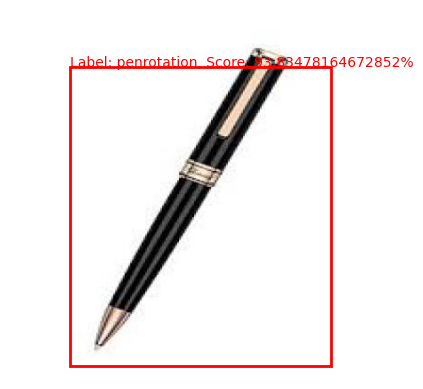

In [77]:
# Switching the model to evaluation mode for inference
model.eval()

# Test Image Path
TEST_DATASET_PATH = '.../pendataset/test/_annotations.csv'
test_ds = pd.read_csv(TEST_DATASET_PATH)
rand_ds_el = randint(0, len(test_ds)-1)

image_path = test_ds.iloc[rand_ds_el, 0]

# Test Image Path
image_path = f'.../pendataset/test/{image_path}'

image = Image.open(image_path).convert("RGB")

transform = get_transform(train=False)
# Image to Tensor
image_tensor = transform(image)

image_tensor = image_tensor.to(device)

with torch.no_grad():
    predictions = model([image_tensor])

# Getting predicted bounding boxes and class labels
boxes = predictions[0]["boxes"].detach().cpu().numpy()
labels = predictions[0]["labels"].detach().cpu().numpy()
scores = predictions[0]["scores"].detach().cpu().numpy()

plt.imshow(image)
ax = plt.gca()
# Visualization of bounding boxes on the test image
for box, label, score in zip(boxes, labels, scores):
    xmin, ymin, xmax, ymax = box
    label = idx2class_name_dict[label.item()]
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor="r", facecolor="none")
    ax.add_patch(rect)
    ax.text(xmin, ymin, f"Label: {label}, Score: {score.item()*100}%", color="r")

plt.axis("off")
plt.show()